# Fold, train-test, sequence creation. Baseline, Simple RNN, LSTM modelling.

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Import data

In [2]:
FILE = '../../db/data/merge/tertiary/logs_.csv'
df = pd.read_csv(FILE, index_col=0)
df.index = pd.to_datetime(df.index)
display(df.head(3))
display(df.tail(3))

,AUD,CAD,CHF,EUR,GBP,JPY,NZD,USD
2005-01-03 00:00:00+00:00,-0.064396,-0.014073,-0.105662,-0.127787,0.028474,0.172005,-0.015203,0.126642
2005-01-03 01:00:00+00:00,-0.006224,-0.067656,-0.119911,-0.035191,-0.030165,0.148821,0.088015,0.022311
2005-01-03 02:00:00+00:00,-0.085077,0.127799,-0.158482,-0.086595,-0.074298,0.183128,-0.067183,0.160709


,AUD,CAD,CHF,EUR,GBP,JPY,NZD,USD
2022-12-27 21:00:00+00:00,-0.093193,0.015155,-0.084192,0.179205,0.008747,-0.063549,-0.015301,0.053128
2022-12-27 22:00:00+00:00,-0.093193,0.015155,-0.084192,0.179205,0.008747,-0.063549,-0.015301,0.053128
2022-12-27 23:00:00+00:00,-0.093193,0.015155,-0.084192,0.179205,0.008747,-0.063549,-0.015301,0.053128


In [3]:
df.shape

(111096, 8)

## Clean unknown data

In [4]:
from datetime import datetime, timedelta
from pytz import UTC

In [5]:
LAST_VALID_DAY = datetime(2022, 8, 31, 9, 0, 0, 0, UTC)
df = df.loc[:LAST_VALID_DAY]
df.shape

(109066, 8)

## Drop NaN and outliers

In [6]:
clean_df = df.dropna()
clean_df.shape

(109066, 8)

## Split train and test data

In [7]:
DAY = datetime.now(UTC) - timedelta(days = 2 * 30)

In [8]:
df_train = df.loc[:DAY - timedelta(hours=1)]
df_test = df.loc[DAY:]
df_train.shape, df_test.shape

((108048, 8), (1018, 8))

## Filter desired columns (optional)

In [29]:
TARGETS = ['EUR'] # List of targets. e.g. ['EUR'] for one or df.columns for not filtering
df_train_filt = df_train[TARGETS]
df_test_filt = df_test[TARGETS]
df_train_filt.shape, df_test_filt.shape

((108048, 1), (1018, 1))

## Scaling

In [30]:
from sklearn.preprocessing import MinMaxScaler

In [31]:
scaler = MinMaxScaler()
df_train_scaled = pd.DataFrame(scaler.fit_transform(df_train_filt), columns=df_train_filt.columns, index=df_train_filt.index)
df_test_scaled = pd.DataFrame(scaler.transform(df_test_filt), columns=df_test_filt.columns, index=df_test_filt.index)
df_train_scaled.shape, df_test_scaled.shape

((108048, 1), (1018, 1))

## Create folds train and validation

In [32]:
from typing import List

In [33]:
FOLD_LENGTH = 2 * 12 * 21 * 24 # 2 year fold size
FOLD_STRIDE = 2 * 21 * 24 # 2 month gap between folds
TRAIN_TEST_RATIO = 0.75
INPUT_LENGTH = 2 * 21 * 24 # 2 month sequence size

In [34]:
def create_folds(df: pd.DataFrame,
                 length: int,
                 stride: int) -> List[pd.DataFrame]:
    '''
    This function slides through the Time Series dataframe of shape (n_timesteps, n_features) to create folds
    - of equal `length`
    - using `stride` between each fold
    
    Returns a list of folds, each as a DataFrame
    '''
    folds = []
    
    for i in range(len(df), 0, -stride):
        if i - length < 0:
            break
        fold = df.iloc[i - length:i]
        folds.insert(0, fold)
            
    return folds

In [35]:
folds = create_folds(df_train_scaled, FOLD_LENGTH, FOLD_STRIDE)
print(f'The function generated {len(folds)} folds.')
print(f'Each fold has a shape equal to {folds[0].shape}.')

The function generated 96 folds.
Each fold has a shape equal to (12096, 1).


In [36]:
folds[-1]

,EUR
2020-07-15 00:00:00+00:00,0.424859
2020-07-15 01:00:00+00:00,0.380548
2020-07-15 02:00:00+00:00,0.410315
2020-07-15 03:00:00+00:00,0.417643
2020-07-15 04:00:00+00:00,0.402112
...,...
2022-07-01 19:00:00+00:00,0.438123
2022-07-01 20:00:00+00:00,0.410649
2022-07-01 21:00:00+00:00,0.410649
2022-07-01 22:00:00+00:00,0.410649


### Create `train` and `test` splits for each fold

In [37]:
def train_val_split(fold: pd.DataFrame,
                    train_ratio: float,
                    input_length: int):
    '''
    Returns a train dataframe and a val dataframe (fold_train, fold_val)
    from which one can sample (X,y) sequences.
    df_train should contain all the timesteps until round(train_val_ratio * len(fold))   
    '''
    last_train_i = round(train_ratio * len(fold))
    fold_train = fold.iloc[:last_train_i]
    fold_val = fold.iloc[last_train_i - input_length:]
    
    return fold_train, fold_val

In [38]:
fold_train, fold_val = train_val_split(folds[-1], TRAIN_TEST_RATIO, INPUT_LENGTH)
fold_train.shape, fold_val.shape

((9072, 1), (4032, 1))

### Create X and y sequences from each fold

#### Get chronological X, y (Option 1)

In [39]:
def get_X_y_strides(fold: pd.DataFrame,
                    input_length: int,
                    output_length: int,
                    stride: int):
    '''
    - slides through a `fold` Time Series (2D array) to create sequences of equal
        * `input_length` for X,
        * `output_length` for y,
    using a temporal gap `sequence_stride` between each sequence
    - returns a list of sequences, each as a 2D-array time series
    '''
    X, y = [], []
    
    for i in range(len(fold), 0, -stride):
        if i - input_length - output_length < 0:
            break
        X_i = fold.iloc[i - input_length: i]
        y_i = fold.iloc[i - input_length - output_length: i - input_length][TARGETS]
        X.insert(0, X_i)
        y.insert(0, y_i)
        
    return np.array(X), np.array(y)

In [40]:
SEQUENCE_STRIDE = 6 # Every 6 hours
OUTPUT_LENGTH = 1 # Number of values to predict

X_train, y_train = get_X_y_strides(fold_train, INPUT_LENGTH, OUTPUT_LENGTH, SEQUENCE_STRIDE)
X_val, y_val = get_X_y_strides(fold_val, INPUT_LENGTH, OUTPUT_LENGTH, SEQUENCE_STRIDE)

X_train.shape, y_train.shape, X_val.shape, y_val.shape

((1344, 1008, 1), (1344, 1, 1), (504, 1008, 1), (504, 1, 1))

#### Get random n sequences (Option 2) 

In [41]:
def get_Xi_yi(fold:pd.DataFrame, 
              input_length:int, 
              output_length:int):
    '''
    - given a fold, it returns one sequence (X_i, y_i)
    - with the starting point of the sequence being chosen at random
    '''
    
    first_possible_start = 0
    last_possible_start = len(fold) - input_length - output_length + 1
    start = np.random.randint(first_possible_start, last_possible_start)
    X_i = fold.iloc[start:start+input_length]    
    y_i = fold.iloc[start+input_length:
                  start+input_length+output_length][TARGETS]
    
    return X_i, y_i

In [42]:
def get_X_y(fold:pd.DataFrame,
            number_of_sequences:int,
            input_length:int,
            output_length:int):
        
    X, y = [], []

    for i in range(number_of_sequences):
        Xi, yi = get_Xi_yi(fold, input_length, output_length)
        X.append(Xi)
        y.append(yi)
        
    return np.array(X), np.array(y)

In [43]:
N_TRAIN_SEQ = 500
N_TEST_SEQ = round(500 * (1 - TRAIN_TEST_RATIO))

In [44]:
X_train, y_train = get_X_y(fold_train, N_TRAIN_SEQ, INPUT_LENGTH, OUTPUT_LENGTH)
X_val, y_val = get_X_y(fold_val, N_TEST_SEQ, INPUT_LENGTH, OUTPUT_LENGTH)
X_train.shape, y_train.shape, X_val.shape, y_val.shape

((500, 1008, 1), (500, 1, 1), (125, 1008, 1), (125, 1, 1))

## Prepare X_test, y_test

In [45]:
X_test, y_test = get_X_y(df_test_scaled, N_TEST_SEQ, INPUT_LENGTH, OUTPUT_LENGTH)
X_test.shape, y_test.shape

((125, 1008, 1), (125, 1, 1))

## Modelling

In [46]:
from typing import Union
from keras.api._v2.keras import Model
from keras.api._v2.keras.optimizers import Optimizer, Adam
from keras.api._v2.keras.models import Sequential
from keras.api._v2.keras.layers import Dense, SimpleRNN, Dropout, LSTM, Lambda
from keras.api._v2.keras.callbacks import EarlyStopping
from keras.api._v2.keras.layers.experimental.preprocessing import Normalization

### Create normalizer (works but not inside the model)

In [47]:
def init_normalizer(X_train):
    n = Normalization()
    n.adapt(X_train)
    return n

### Create baseline model

It will predict the last temperature, no need to `fit` it as it has no params.

In [48]:
def init_baseline():

    model = Sequential()
    model.add(Lambda(lambda x: x[:,-1,:, None]))

    return model

### Create simple RNN model

In [49]:
def init_srnn_model(X_train, y_train):
    
    regressor = Sequential()

    regressor.add(SimpleRNN(50, return_sequences=True, input_shape=X_train[0].shape))
    regressor.add(Dropout(0.2))

    regressor.add(SimpleRNN(50, return_sequences=True))
    regressor.add(Dropout(0.2))

    regressor.add(SimpleRNN(50, return_sequences=True))
    regressor.add(Dropout(0.2))

    regressor.add(SimpleRNN(50))

    regressor.add(Dense(y_train.shape[1], activation="linear"))
    
    return regressor

### Create LSTM model

In [50]:
def init_lstm_model(X_train, y_train):
        
    lstm = Sequential()
    
    lstm.add(LSTM(32, return_sequences=True, recurrent_dropout=0.2))
    lstm.add(LSTM(32, recurrent_dropout=0.2))
    
    lstm.add(Dense(y_train.shape[1], activation='linear'))
    
    return lstm

### Create compile and fit functions

In [51]:
def compile_model(model: Model,
                  optimizer:Union[str, Optimizer]='adam',
                  loss='mse',
                  metrics:list=['mae']):
    
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    
    return model

In [52]:
def fit_model(model: Model,
              X, y,
              X_val, y_val,
              epochs:int=50,
              batch_size:int=32,
              verbose:int=1):
    
    es = EarlyStopping(patience=3,
                       mode="min",
                       restore_best_weights=True)

    history = model.fit(X, y,
                        epochs=epochs,
                        batch_size=batch_size,
                        validation_data=(X_val, y_val),
                        callbacks=[es])
    
    return model, history

### Initialise, compile and train the models

In [54]:
baseline = init_baseline()
baseline = compile_model(baseline)
baseline_score = baseline.evaluate(X_test, y_test)

print(f"- The Baseline MAE on the test set is equal to {round(baseline_score[1],6)} log return")

4/4 [==============================] - 0s 2ms/step - loss: 0.0039 - mae: 0.0474
- The Baseline MAE on the test set is equal to 0.047361 log return


In [55]:
srnn = init_srnn_model(X_train, y_train)
srnn = compile_model(srnn)
srnn, history = fit_model(srnn, X_train, y_train, X_val, y_val)
srnn_score = srnn.evaluate(X_test, y_test)

print(f"- The Simple RNN MAE on the test set is equal to {round(srnn_score[1],6)} log return")

Epoch 1/50
16/16 [==============================] - 21s 1s/step - loss: 0.1699 - mae: 0.3179 - val_loss: 0.0435 - val_mae: 0.2052
Epoch 2/50
16/16 [==============================] - 19s 1s/step - loss: 0.0581 - mae: 0.1925 - val_loss: 0.0147 - val_mae: 0.1163
Epoch 3/50
16/16 [==============================] - 19s 1s/step - loss: 0.0314 - mae: 0.1434 - val_loss: 0.0043 - val_mae: 0.0577
Epoch 4/50
16/16 [==============================] - 20s 1s/step - loss: 0.0197 - mae: 0.1124 - val_loss: 0.0018 - val_mae: 0.0330
Epoch 5/50
16/16 [==============================] - 20s 1s/step - loss: 0.0121 - mae: 0.0876 - val_loss: 0.0011 - val_mae: 0.0238
Epoch 6/50
16/16 [==============================] - 20s 1s/step - loss: 0.0071 - mae: 0.0680 - val_loss: 0.0011 - val_mae: 0.0240
Epoch 7/50
16/16 [==============================] - 20s 1s/step - loss: 0.0066 - mae: 0.0637 - val_loss: 0.0011 - val_mae: 0.0242
Epoch 8/50
16/16 [==============================] - 21s 1s/step - loss: 0.0060 - mae: 0.06

In [56]:
lstm = init_lstm_model(X_train, y_train)
lstm = compile_model(lstm)
lstm, history = fit_model(lstm, X_train, y_train, X_val, y_val)
lstm_score = lstm.evaluate(X_test, y_test)

print(f"- The LSTM MAE on the test set is equal to {round(lstm_score[1],6)} log return")

Epoch 1/50
16/16 [==============================] - 42s 2s/step - loss: 0.0593 - mae: 0.2056 - val_loss: 0.0142 - val_mae: 0.1150
Epoch 2/50
16/16 [==============================] - 38s 2s/step - loss: 0.0038 - mae: 0.0521 - val_loss: 0.0022 - val_mae: 0.0402
Epoch 3/50
16/16 [==============================] - 38s 2s/step - loss: 0.0011 - mae: 0.0270 - val_loss: 0.0011 - val_mae: 0.0225
Epoch 4/50
16/16 [==============================] - 38s 2s/step - loss: 7.4995e-04 - mae: 0.0211 - val_loss: 0.0010 - val_mae: 0.0213
Epoch 5/50
16/16 [==============================] - 38s 2s/step - loss: 7.0445e-04 - mae: 0.0200 - val_loss: 9.9459e-04 - val_mae: 0.0214
Epoch 6/50
16/16 [==============================] - 38s 2s/step - loss: 7.6511e-04 - mae: 0.0207 - val_loss: 0.0010 - val_mae: 0.0218
Epoch 7/50
16/16 [==============================] - 38s 2s/step - loss: 7.0270e-04 - mae: 0.0193 - val_loss: 9.9397e-04 - val_mae: 0.0210
Epoch 8/50
16/16 [==============================] - 40s 2s/step - 

## Make predictions and plot

In [57]:
y_pred_baseline = baseline.predict(X_test)
y_pred_srnn = srnn.predict(X_test)
y_pred_lstm = lstm.predict(X_test)

y_pred_baseline.shape, y_pred_srnn.shape, y_pred_lstm.shape

4/4 [==============================] - 2s 421ms/step


((125, 1, 1), (125, 1), (125, 1))

In [63]:
y_pred_lstm

array([[0.42291185],
       [0.41945782],
       [0.41302475],
       [0.42019227],
       [0.41909268],
       [0.416043  ],
       [0.42121366],
       [0.4222313 ],
       [0.42019227],
       [0.42019227],
       [0.42019227],
       [0.42019227],
       [0.42121366],
       [0.416043  ],
       [0.41814765],
       [0.42291185],
       [0.416043  ],
       [0.42019227],
       [0.41909268],
       [0.41909268],
       [0.41302475],
       [0.416043  ],
       [0.41814765],
       [0.42291185],
       [0.42121366],
       [0.42121366],
       [0.41814765],
       [0.41490644],
       [0.416043  ],
       [0.41909268],
       [0.41490644],
       [0.41490644],
       [0.416043  ],
       [0.4222313 ],
       [0.41302475],
       [0.42121366],
       [0.42121366],
       [0.41302475],
       [0.42291185],
       [0.41302475],
       [0.4222313 ],
       [0.42121366],
       [0.416043  ],
       [0.41909268],
       [0.42121366],
       [0.41490644],
       [0.41909268],
       [0.422

In [58]:
import seaborn as sns

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


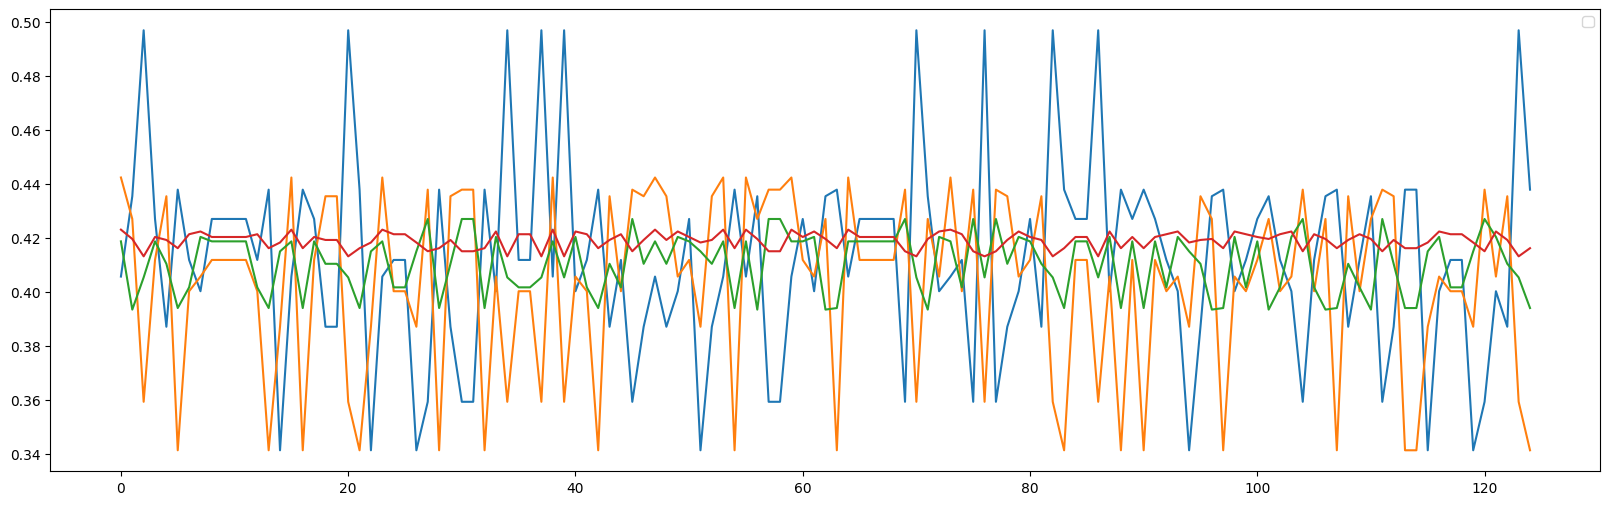

In [73]:
fig = plt.figure(figsize=(20,6))
sns.lineplot(data=y_test.reshape((125)))
sns.lineplot(data=y_pred_baseline.reshape((125)))
sns.lineplot(data=y_pred_srnn.reshape((125)))
sns.lineplot(data=y_pred_lstm.reshape((125)))
fig.set_label('LSTM')
plt.legend();